In [186]:
using JLD, Mamba
include("gyncycle.jl")

acceptance(mc) = mapslices(mc,[1,2]) do mc
    n = size(mc,1)
    sum([mc[i,:,:] != mc[i+1,:,:] for i in 1:n-1]) / (n-1);
end

mergeparms!(aparms, sparms) = (aparms[SAMPLEPARMS]=sparms; aparms)

mergeparms(aparms,sparms) = mergeparms!(copy(aparms), sparms)

function loglikelihood(mc::Array{Float64,3}, data::Matrix)
    mapslices(mc.value, 2) do modelparms
        aparms = mergeparms(parms, modelparms[1:length(SAMPLEPARMS)])
        y0 = modelparms[length(SAMPLEPARMS)+1:end]
        loglikelihood(data, aparms, y0)
    end
end

mergepersons(mcs) = cat(3,map(x->x[1:minimum(map(x->size(x,1), mcs)),:,:],mcs)...);

loglikelihood(mc::AbstractChains, data::Matrix) = loglikelihood(mc.value, data);

In [187]:
mcs = load("walks.jld")["mc"]
map(size,mcs)

3-element Array{Any,1}:
 (11700,115,1)
 (11700,115,1)
 (11600,115,1)

In [188]:
mc=mergepersons(mcs)
acceptance(mc)

1x1x3 Array{Float64,3}:
[:, :, 1] =
 0.900336

[:, :, 2] =
 0.865333

[:, :, 3] =
 0.916027

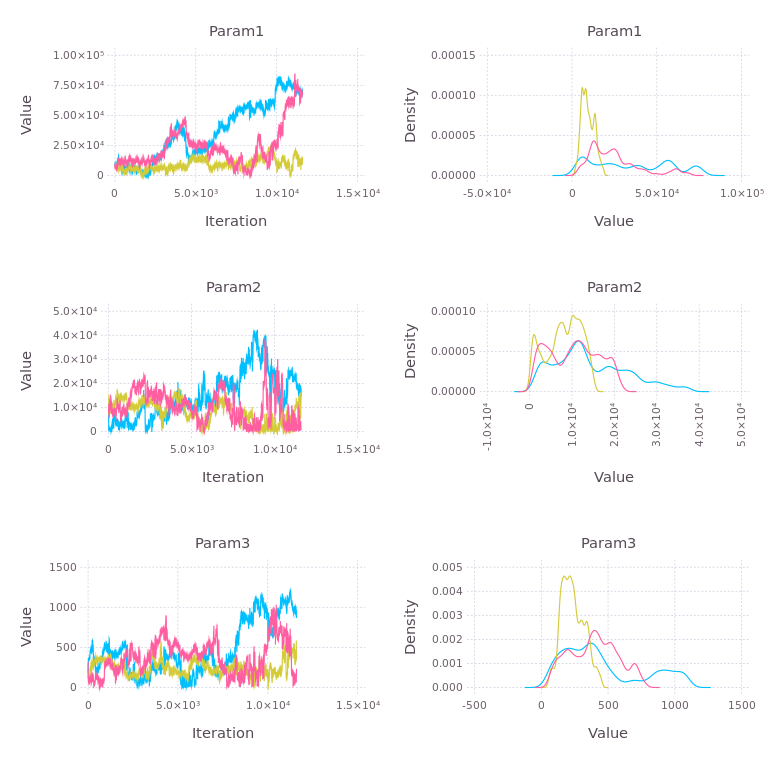

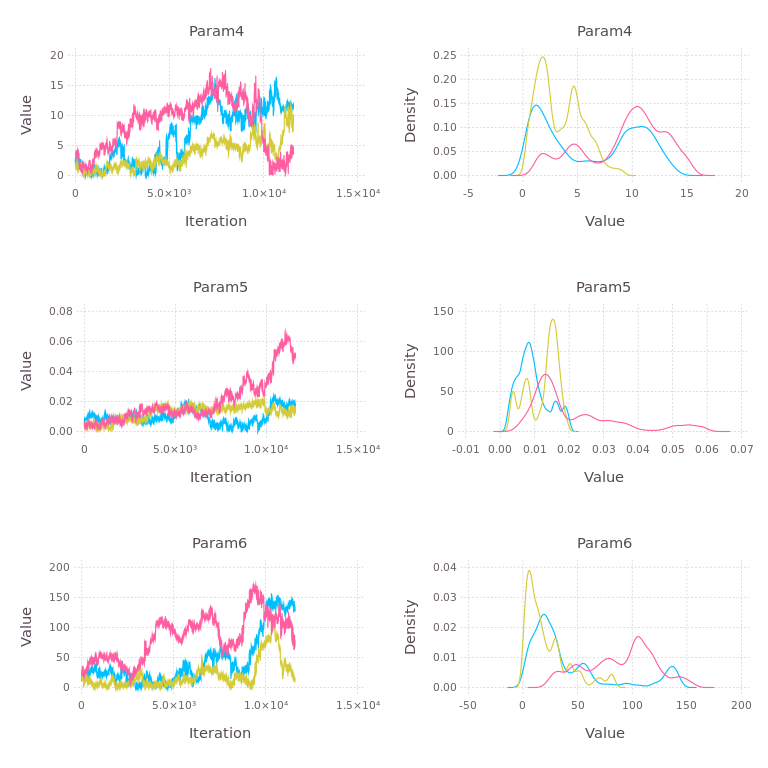

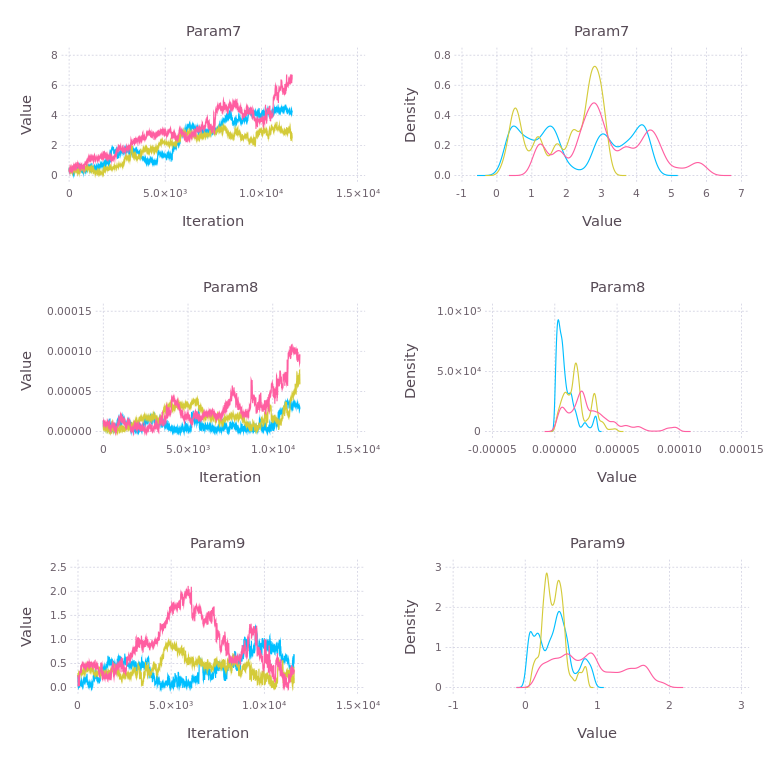

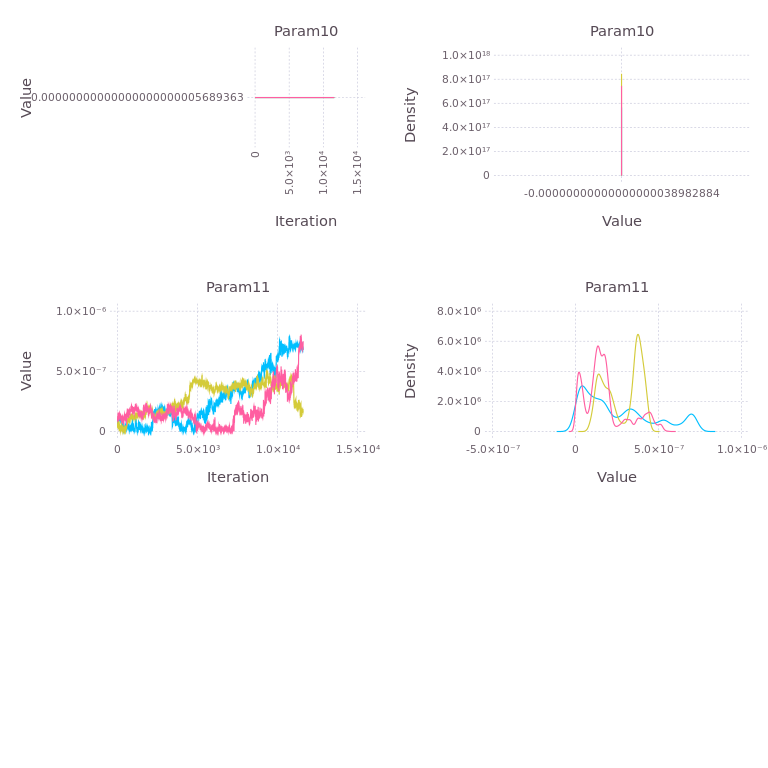

In [189]:
draw(plot(Chains(mc[:,[1:5;95:100],:])), ask=false, fmt=:png)

In [190]:
using Clustering
pmc = mc[:,:,1]

means = mapslices(Base.mean, pmc, 1)
scale = diagm(vec(means))
km = kmeans(inv(scale)*reshape(pmc,size(pmc)[[1,2]])',3)
(km.counts, scale * km.centers)

([5696,3908,1996],
115x3 Array{Float64,2}:
 16404.4          47837.0          71998.7        
  7404.19         23614.5          19069.9        
   287.258          480.652          954.863      
     2.38286          9.84486         11.8622     
     0.00938822       0.00741749       0.0155855  
     0.376642         0.805031         1.00877    
     0.000232143      0.000369225      0.000509736
     3.16242          4.39059          6.79222    
     1.41834          3.79957          0.631671   
    80.9857          80.7204         244.186      
    84.9085         164.6            162.611      
   182.085          434.199          134.848      
 19119.3          21030.0          38685.3        
     ⋮                                            
     0.0186505        0.0218865        0.0265752  
     0.0367936        0.0201641        0.0620448  
    54.3538          68.9383          51.4146     
     4.58209          6.5087          16.9791     
     2.41335          2.12432          